<a href="https://colab.research.google.com/github/yarakyrychenko/llm-abm/blob/main/LLM_ABM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Change Runtime to GPU (T4)

# Imports

In [1]:
!pip install Mesa==2.2.0
!pip install convokit
!pip install networkx[default]
!pip install sentence-transformers
!pip install seaborn
!pip install ctransformers[cuda]
!pip install --upgrade git+https://github.com/huggingface/transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import mesa, convokit
import networkx as nx
import numpy as np, pandas as pd
from convokit import Corpus
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.en import English
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

# ABM Set-Up

In [3]:
class PlatformGrid(mesa.space.NetworkGrid):
    def __init__(self, g):
        g.remove_edges_from(nx.selfloop_edges(g))
        super().__init__(g)

    def get_followers(self, node_id: int):
        neighborhood = list(set([edge[0] for edge in self.G.in_edges(node_id)]))
        return self.get_cell_list_contents(neighborhood)

    def get_following(self, node_id: int):
        neighborhood = list(set([edge[1] for edge in self.G.out_edges(node_id)]))
        return self.get_cell_list_contents(neighborhood)


In [4]:
class BaseLLMAgent(mesa.Agent):
    """
    Base LMM agents can read posts, post, reply, and follow/unfollow.

    TO IMPLEMENT
        # proper speaker opinion, belief and emotion logging
        #
        # News timeline
    """

    def __init__(self, self_description, model):

        super().__init__(self_description["id"], model)

        self.id = self_description["id"]
        self.self_description = self_description["description"]
        num_agents = len(self.model.agent_descriptions)
        self.homefeed = Corpus.from_pandas(
            pd.DataFrame({
                'id': range(num_agents),
                'timestamp':[-self.model.num_post_see]*num_agents,
                'text':["-1"]*num_agents,
                'speaker': [agent["id"] for agent in self.model.agent_descriptions],
                'reply_to':[0]*num_agents,
                'conversation_id': [0]*num_agents
                }))


    def get_full_sents(self, post):
        punkt = {'!', '.', '?'}
        sents = [sent.text for sent in self.model.sentence_tokenizer(post).sents]
        post = " ".join(sents[:-1]) if (len(sents) > 1) and (sents[-1][-1] not in punkt) else " ".join(sents)
        return post.replace("\n","").replace('"',"").replace('#',"")

    def format_prompt(self, speaker, full_convo_text, prompt_type):
        prompt = self.model.prompts[prompt_type].replace("[DESCRIPTION]", self.self_description).replace("[TWEET]", full_convo_text).replace("[HANDLE]",self.id).replace("[SPEAKER]", f"@{speaker.id}")
        all_opinions_on_speaker = self.model.corpus.get_speaker(self.id).meta["opinion"][speaker.id]
        if len(all_opinions_on_speaker) != 0:
            return prompt.replace("[OPINION]", f'You have previously described @{speaker.id} as: "{all_opinions_on_speaker[-1][0]}".')
        else:
            return prompt.replace("[OPINION]", "")

    def generate_post(self, prompt, reply_to=None):
        post = self.get_full_sents(self.model.generator(prompt)[0]["generated_text"].replace(prompt, ""))
        self.model.current_utt_id += 1

        full_post = convokit.Utterance(**{
                'id': str(self.model.current_utt_id),
                'timestamp': self.model.schedule.steps,
                "text": post,
                "speaker": self.model.corpus.get_speaker(self.id),
                "reply_to": None if reply_to == None else reply_to["id"],
                "conversation_id": str(self.model.current_utt_id) if reply_to == None else reply_to["conversation_id"]
                })

        return full_post


    def follow(self, id):
        agent = self.model.schedule._agents[self.model.agent_order[id]]
        self.model.grid.G.add_edge(self.pos,agent.pos)
        self.current_step_info["followed"].append(agent.id)
        print(f"\t{self.id} started following {agent.id}")


    def unfollow(self, id):
        agent = self.model.schedule._agents[self.model.agent_order[id]]
        self.model.grid.G.remove_edge(self.pos,agent.pos)
        self.current_step_info["unfollowed"].append(agent.id)
        print(f"\t{self.id} unfollowed {agent.id}")


    def push_to_followers(self, post_convo, meta=None):
        # pushes a post to all the people who follow this agent
        followers = self.model.grid.get_followers(self.pos)
        for follower in followers:
            if follower.id != self.id:
                for utt in post_convo:
                    if not follower.homefeed.has_utterance(utt.id):
                        follower.homefeed.add_utterances([utt])


    def read_convo(self, utt_list):
        # complies a conversation into one text
        full_convo_text = ""
        for i, utt in enumerate(utt_list):
            speaker = f"@{utt.speaker.id}" if utt.speaker.id != self.id else "You"
            if i == 0:
                full_convo_text += f'{speaker} wrote: "{utt.text}"\n'
            else:
                full_convo_text += f'{speaker} replied: "{utt.text}"\n'
        return full_convo_text

    def reply(self, last_utt, full_convo_text, meta=None):
        if self.model.verbose:
            print(f"\t{self.id} replied to post #{last_utt.id}")

        formatted_prompt = self.format_prompt(last_utt.speaker, full_convo_text, "reply_prompt")
        full_post = self.generate_post(formatted_prompt, reply_to={"conversation_id":last_utt.conversation_id,"id":last_utt.id})
        full_post.meta = {"likes": 0, "reposts": 0, "topic": last_utt.meta["topic"]}

        self.model.corpus.add_utterances([full_post])
        self.homefeed.add_utterances([full_post])
        self.push_to_followers(self.model.corpus.get_conversation(last_utt.conversation_id).get_chronological_utterance_list())

    def step(self):
        pass



In [5]:
class LLMAgent(BaseLLMAgent):

    def __init__(self, self_description, model):

        super().__init__(self_description, model)
        self.enough_posts = False
        self.current_step_info= {"likes":[],"reposts":[],"timeline":[],"followed":[],"unfollowed":[]}

        for utt in self.homefeed.iter_utterances():
            utt.add_meta("likes", 0)
            utt.add_meta("reposts", 0)
            utt.add_meta("topic", "")


    def decision_bool(self,decision_text):
        return True if "yes" in decision_text.lower() else False


    def generate_decision(self, formatted_prompt):
        return self.decision_bool(self.model.generator(formatted_prompt)[0]["generated_text"].replace(formatted_prompt, ""))


    def get_speaker_opinion(self, speaker, full_convo_text):
        all_opinions_on_speaker = self.model.corpus.get_speaker(self.id).meta["opinion"][speaker.id]
        if len(all_opinions_on_speaker) != 0:
            prompt = self.model.prompts["opinion_prompt"].replace("[OPINION]", all_opinions_on_speaker[-1][0])
        else:
            prompt = self.model.prompts["first_opinion_prompt"]
        prompt = prompt.replace("[DESCRIPTION]", self.self_description).replace("[TWEET]", full_convo_text).replace("[SPEAKER]", f"@{speaker.id}").replace("[HANDLE]",self.id)
        self.model.corpus.get_speaker(self.id).meta["opinion"][speaker.id].append([self.get_full_sents(self.model.generator(prompt)[0]["generated_text"].replace(prompt, "")),self.model.schedule.steps])


    def like(self, last_utt):
        self.model.corpus.get_utterance(last_utt.id).meta["likes"] += 1
        self.current_step_info["likes"].append(last_utt.id)
        print(f"\t{self.id} liked post #{last_utt.id}")


    def repost(self, last_utt):
        self.model.corpus.get_utterance(last_utt.id).meta["reposts"] += 1
        self.current_step_info["reposts"].append(last_utt.id)
        self.push_to_followers(self.model.corpus.get_conversation(last_utt.conversation_id).get_chronological_utterance_list())
        print(f"\t{self.id} reposted post #{last_utt.id}")


    def step(self):
        if self.model.verbose:
            print("\nAgent "+self.id+" active")

        p = self.model.random.random()
        self.current_step_info={"likes":[],"reposts":[],"timeline":[],"followed":[],"unfollowed":[]}

        if not self.enough_posts:
            self.enough_posts = True if self.model.num_post_see + len(self.model.agents) <= len([utt for utt in self.homefeed.iter_utterances()]) else False

        if p <= self.model.P1 and self.enough_posts:
            self.current_step_info["timeline"] = self.model.feed_algorithm(self)

            for convo in self.current_step_info["timeline"]:

                convo_obj = self.model.corpus.get_conversation(convo) # important: the convo is from the model.corpus not the homefeed
                utt_list = convo_obj.get_chronological_utterance_list()[-self.model.num_post_read:]
                last_utt = utt_list[-1]

                if self.model.verbose:
                    print("\tConvo: " + convo)
                    print("\tUtterance: "+last_utt.text)

                if last_utt.speaker.id != self.id:

                    full_convo_text = self.read_convo(utt_list)

                    # decide if you want to like a post (&like it)
                    if self.generate_decision(self.format_prompt(last_utt.speaker, full_convo_text, "like_prompt")):
                        self.like(last_utt)
                    # decide if you want to repost (&repost)
                    if self.generate_decision(self.format_prompt(last_utt.speaker, full_convo_text, "repost_prompt")):
                        self.repost(last_utt)

                    for speaker_obj in set([utt.speaker for utt in utt_list]):
                        if speaker_obj.id != self.id:
                            followings = [following.id for following in self.model.grid.get_following(self.pos)]
                            self.get_speaker_opinion(speaker_obj, full_convo_text)

                            if speaker_obj.id not in set(followings):
                                # decide if you want to follow (&follow)
                                if self.generate_decision(self.format_prompt(speaker_obj, full_convo_text, "follow_prompt")):
                                    self.follow(speaker_obj.id)
                            else:
                                # decide if you want to unfollow (&unfollow)
                                if self.generate_decision(self.format_prompt(speaker_obj, full_convo_text, "unfollow_prompt")):
                                    self.unfollow(speaker_obj.id)

                    if self.generate_decision(self.format_prompt(last_utt.speaker, full_convo_text, "reply_prompt")):
                        self.reply(last_utt, full_convo_text)
                        # stop the loop as soon as you chose to & replied to one convo
                        break

        elif p <= self.model.P1 and not self.enough_posts:

            topic = self.random.choice(self.model.topics)
            prompt = self.model.prompts["first_prompt"].replace("[DESCRIPTION]", self.self_description).replace("[TOPIC]",topic)

            full_post = self.generate_post(prompt)
            full_post.meta = {"likes": 0, "reposts": 0, "topic": topic}

            print(full_post)

            self.model.corpus.add_utterances([full_post])
            self.homefeed.add_utterances([full_post])
            self.push_to_followers([full_post])

        elif self.model.P1 < p <= self.model.P1 + self.model.P2:

            topic = self.random.choice(self.model.topics)
            previous_posts = [f' - "{self.homefeed.get_utterance(id).text}"' for id in self.homefeed.get_speaker(self.id).get_utterance_ids(lambda utt: True if utt.meta["topic"]==topic and utt.reply_to==None else False)]
            prompt = self.model.prompts["second_prompt"].replace("[DESCRIPTION]", self.self_description).replace("[TOPIC]", topic).replace("[PREVIOUSPOSTS]", "\n".join(previous_posts))

            full_post = self.generate_post(prompt)
            full_post.meta = {"likes": 0, "reposts": 0, "topic": topic}

            print(full_post)
            self.model.corpus.add_utterances([full_post])
            self.homefeed.add_utterances([full_post])
            self.push_to_followers([full_post])

        else:
            pass




In [6]:
from ctransformers import AutoModelForCausalLM
from transformers import AutoTokenizer, pipeline

# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/zephyr-7B-alpha-GGUF",
    model_file="zephyr-7b-alpha.Q4_K_M.gguf",
    model_type="mistral",
    gpu_layers=1024,
    hf=True,
    context_length=8192
)
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceH4/zephyr-7b-alpha")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

zephyr-7b-alpha.Q4_K_M.gguf:   0%|          | 0.00/4.37G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [7]:
# Pipeline for tweet generation
generator = pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    max_new_tokens=50,
    repetition_penalty=1.1,
    temperature = 0.9,
    top_p=.7,
    seed=None,
    do_sample=True
    )

# Sentence encoder
#sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# Sentence tokenizer
nlp = English()
nlp.add_pipe("sentencizer");

In [8]:
def compute_mean_model_similarity(model):
    agent_descriptions = [agent.descriptions[-1]["emb"] for agent in model.schedule.agents]
    return np.mean(cosine_similarity(agent_descriptions), axis=0)

def compute_mean_agent_similarity(agent):
    agent_descriptions = np.array([agent2.descriptions[-1]["emb"] for agent2 in agent.model.schedule.agents])
    sim = cosine_similarity(np.array([agent.descriptions[-1]["emb"]]),agent_descriptions)
    return np.mean(sim)

max_steps=10
def collect_model_corpus(model):
    if model.schedule.steps == max_steps:
        return model.corpus
    else:
        return ""

def collect_network(model):
    return model.grid.G.copy()

def collect_agent_corpus(agent):
    if agent.model.schedule.steps == max_steps:
        return agent.homefeed
    else:
        return ""


In [9]:
class LLMModel(mesa.Model):

    def __init__(self, agent_descriptions, llmprompts, topics,
                 generator=generator,
                 #sentence_model=sentence_model,
                 sentence_tokenizer=nlp,
                 num_post_see = 5,
                 num_post_read = 5,
                 P_read_timeline=.5, P_post_about_topic=1,
                 seed=None):

        self.verbose = True
        self.agent_descriptions  = [{"id":desc.split("::")[0],"description":desc.split("::")[1]} for desc in agent_descriptions.split("\n")]
        self.topics = topics.split("\n")
        self.prompts = {prompt.split("::")[0]:prompt.split("::")[1] for prompt in llmprompts.split("\t")}
        self.current_utt_id = len(self.agent_descriptions)
        self.num_post_see = num_post_see # number of posts users see in their timelines (both local and homefeed)
        self.num_post_read = num_post_read # number of posts users read in a convo (latest)
        self.agent_order = {}
        num_agents = len(self.agent_descriptions)

        self.corpus = Corpus.from_pandas(pd.DataFrame({'id': range(self.current_utt_id),
                                'timestamp':[-self.num_post_see]*num_agents,
                                'text':["-1"]*num_agents,
                                'speaker': [agent["id"] for agent in self.agent_descriptions],
                                'reply_to':[0]*num_agents,
                                'conversation_id': [0]*num_agents,
                                "meta.likes":[0]*num_agents,
                                "meta.reposts":[0]*num_agents,
                                "meta.topic":[0]*num_agents}))

        spk_dict = {agent["id"]: [] for agent in self.agent_descriptions}
        for speaker in self.corpus.iter_speakers():
            speaker.add_meta("opinion", spk_dict)


        self.P1 = P_read_timeline # probability of reading the timeline (maybe reposting or replying)
        self.P2 = P_post_about_topic # probability of posting on a topic

        self.generator = generator
        self.sentence_tokenizer = sentence_tokenizer

        #ba = nx.barabasi_albert_graph(len(self.agent_descriptions), n_followers, seed=None, initial_graph=None)
        self.grid = PlatformGrid(nx.scale_free_graph(len(self.agent_descriptions), seed=seed, initial_graph=None))

        self.schedule = mesa.time.RandomActivation(self)
        self.random = np.random.default_rng(seed)
        self.running = True

        # Initializing all agents and bots
        for i in range(len(self.agent_descriptions)):
            a = LLMAgent(self_description=self.agent_descriptions[i], model=self)
            self.schedule.add(a)
            self.agent_order[a.id] = i

            # Place agent on an empty node
            nodeid = self.random.integers(len(self.agent_descriptions))
            while not self.grid.is_cell_empty(nodeid):
                nodeid = self.random.integers(len(self.agent_descriptions))
            self.grid.place_agent(a, nodeid)



        # Logging in the data
        self.datacollector = mesa.DataCollector(
            model_reporters={
                            "corpus": collect_model_corpus,
                            "network": collect_network
                            #"similarity": compute_mean_agent_similarity
                            },
            agent_reporters={
                            "id": "id",
                            "pos": "pos",
                            "likes": lambda a: a.current_step_info["likes"],
                            "reposts": lambda a: a.current_step_info["reposts"],
                            "timeline": lambda a: a.current_step_info["timeline"],
                            "followed": lambda a: a.current_step_info["followed"],
                            "unfollowed": lambda a: a.current_step_info["unfollowed"],
                            "homefeed": collect_agent_corpus
                            }
        )
        self.datacollector.collect(self)

    def feed_algorithm(self, agent):
        # return the N most recent conversations (chronological)
        if len(self.grid.get_following(agent.pos)) == 0:
            random_convo = self.corpus.random_conversation()
            feed = [random_convo.id]
            for utt in random_convo.iter_utterances():
                if not agent.homefeed.has_utterance(utt.id):
                    utt2 = convokit.Utterance(**{
                        'id': utt.id,
                        'timestamp': utt.timestamp,
                        "text": utt.text,
                        "speaker": agent.homefeed.get_speaker(utt.speaker.id),
                        "reply_to": utt.reply_to,
                        "conversation_id": utt.conversation_id,
                        # you forgot about the metadata
                        })
                    agent.homefeed.add_utterances([utt2])
        else:
            feed = agent.homefeed.get_conversation_ids(lambda convo :
                                                       convo.get_chronological_utterance_list()[-1].timestamp >= self.schedule.steps - self.num_post_see)
            if len(feed) > self.num_post_see:
                feed = list(self.random.choice(feed, size=self.num_post_see, replace=False))

        return feed

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

        if self.schedule.steps % 10 == 0:
            self.corpus.print_summary_stats()


NameError: name 'generator' is not defined

# Run ABM

In [ ]:
agent_descriptions = """Lisa::You are @Lisa, a staunch Republican voter from Texas, residing in a conservative town. With a deep belief in limited government, traditional values, and free-market principles, you actively engage in local politics. You often listens to conservative talk radio and values candidates who prioritize national security and individual liberties.
Alex::You are @Alex, a passionate Democrat voter in your early 40s. Living in New York City, you advocate for social justice, environmental issues, and healthcare reform. Engaged in grassroots activism, you attend protests and support candidates promoting equality, affordable education, and progressive policies. You value inclusivity and government intervention for societal betterment.
David::You are @David, a dedicated Republican voter in Ohio. You are a middle-aged manufacturing professional residing in a suburban neighborhood. You emphasize traditional family values, Second Amendment rights, and economic conservatism. You appreciate candidates who prioritize job growth, support the energy industry, and advocate for a strong national defense.
Nancy::You are @Nancy, a dedicated US Democrat hailing from a progressive city in California. With a passion for social justice, environmental issues, and healthcare reform, you actively participate in grassroots movements and community organizing. You are well-informed about progressive policies and value candidates who champion civil rights, affordable healthcare, and environmental sustainability.
Sophie::You are @Sophie, an Independent voter in her late 30s from Colorado. Striving for a balanced approach, you prioritize pragmatic solutions over strict party lines. Living in a suburban community, you value candidates who promote bipartisan collaboration, fiscal responsibility, and sustainable environmental policies."""

In [ ]:
other_descriptions =

In [ ]:
llmprompts = """tweet_prompt::<|system|>
[DESCRIPTION]</s>
<|user|>
You just read this conversation: "[TWEET]"
[OPINION]
Write a short post replying to the last post in the conversation above. Remember: you are @[HANDLE].</s>
<|assistant|>\tfirst_prompt::<|system|>
[DESCRIPTION]</s>
<|user|>
Write a short post about [TOPIC].</s>
<|assistant|>\tsecond_prompt::<|system|>
[DESCRIPTION]</s>
<|user|>
You previously wrote about [TOPIC]:
[PREVIOUSPOSTS]
Write a new short post about [TOPIC].</s>
<|assistant|>\tlike_prompt::<|system|>
[DESCRIPTION]</s>
<|user|>
You just read this conversation: "[TWEET]"
Would you "Favorite"/"Like" the last post in the conversation above? Remember: you are @[HANDLE]. Answer only "Yes" or "No" and nothing else.</s>
<|assistant|>\trepost_prompt::<|system|>
[DESCRIPTION]</s>
<|user|>
You just read this conversation: "[TWEET]"
Would you share the last post in the conversation above with your followers? Remember: you are @[HANDLE]. Answer only "Yes" or "No" and nothing else.</s>
<|assistant|>\treply_prompt::<|system|>
[DESCRIPTION]</s>
<|user|>
You just read this conversation: "[TWEET]"
[OPINION]
Would you write a reply to the last post in the conversation above? Remember: you are @[HANDLE]. Answer only "Yes" or "No" and nothing else.</s>
<|assistant|>\tfollow_prompt::<|system|>
[DESCRIPTION]</s>
<|user|>
You just read this conversation: "[TWEET]"
You have previously described [SPEAKER] as: "[OPINION]".
Would you follow [SPEAKER]? Remember: you are @[HANDLE]. Answer only "Yes" or "No" and nothing else.</s>
<|assistant|>\tunfollow_prompt::<|system|>
[DESCRIPTION]</s>
<|user|>
You just read this conversation: "[TWEET]"
You have previously described [SPEAKER] as: "[OPINION]".
Would you stop following [SPEAKER]? Remember: you are @[HANDLE]. Answer only "Yes" or "No" and nothing else.</s>
<|assistant|>\tfirst_opinion_prompt::<|system|>
[DESCRIPTION]</s>
<|user|>
You just read this conversation: "[TWEET]"
Describe [SPEAKER] in one sentence. Remember: you are @[HANDLE].</s>
<|assistant|>\topinion_prompt::<|system|>
[DESCRIPTION]</s>
<|user|>
You just read this conversation: "[TWEET]"
You have previously described [SPEAKER] as: "[OPINION]".
Describe [SPEAKER] in one sentence incorporating both the conversation and your previous opinion. Remember: you are @[HANDLE].</s>
<|assistant|>\tsummary_prompt::<|system|>
You are an impartial assistant helping to summarize tweets and user opinions about them. </s>
<|user|>
A character is described as: "[DESCRIPTION]".
The character reads these tweets made by someone else and has the following opinions about them:
"[TWEETS]"
Please summarize the tweets and opinions of the character.</s>
<|assistant|>"""


In [ ]:
topics = """Democrats
Republicans
Trump
Biden"""

other_topics = """Healthcare
Religion
Putin"""

In [ ]:
n_iters = 1
params = {
        "agent_descriptions": other_descriptions,
        "llmprompts": llmprompts,
        "topics": topics,
        "num_post_see": 3,
        "num_post_read": 3,
        "P_read_timeline": .6,
        "P_post_about_topic": .2,
        #"seed": 123
        }

results = mesa.batch_run(
    LLMModel,
    parameters=params,

    iterations=n_iters,
    max_steps=max_steps,

    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)

  0%|          | 0/1 [00:00<?, ?it/s]


5it [00:00, 3655.49it/s]

5it [00:00, 6527.08it/s]

5it [00:00, 7492.50it/s]

5it [00:00, 7023.28it/s]

5it [00:00, 6202.76it/s]

5it [00:00, 6311.02it/s]



Agent Lisa active
Utterance(id: '6', conversation_id: 6, reply-to: None, speaker: Speaker(id: 'Lisa', vectors: [], meta: ConvoKitMeta({'opinion': {'Lisa': [], 'Alex': [], 'David': [], 'Nancy': [], 'Sophie': []}})), timestamp: 0, text: 'Democrats may claim to care about the working class, but their policies of high taxes, excessive regulation, and socialist programs only hurt small businesses and stifle economic growth.', vectors: [], meta: {'likes': 0, 'reposts': 0, 'topic': 'Democrats'})

Agent Alex active
Utterance(id: '7', conversation_id: 7, reply-to: None, speaker: Speaker(id: 'Alex', vectors: [], meta: ConvoKitMeta({'opinion': {'Lisa': [], 'Alex': [], 'David': [], 'Nancy': [], 'Sophie': []}})), timestamp: 0, text: "Republicans continue to prioritize tax breaks for the wealthy over investing in our communities' future. It's time for them to put people before profits and work towards a more equitable society. ", vectors: [], meta: {'likes': 0, 'reposts': 0, 'topic': 'Republicans'}

In [ ]:
labs = {row["pos"]: row["id"] for row in results[0:len(agent_descriptions.split("\n"))]}
affiliations = {"Lisa":"R","David":"R", "Olivia":"R",
        "Alex":"D", "Nancy": "D",
        "Sophie": "I","Mike":"L","Emily":"G","Jack":"I"}
colors = {"R":"lightcoral",
        "D":"cornflowerblue",
        "I": "grey",
        "L": "cornsilk",
        "G": "mediumseagreen"}

In [ ]:
speaker_df = pd.DataFrame({"node_id": labs.keys(),
                           "handle": labs.values(),
                           "affiliation": [affiliations[person] for person in labs.values()],
                           "color": [colors[affiliations[person]] for person in labs.values()]})
color_map = [color for color in speaker_df.sort_values("node_id")["color"]]

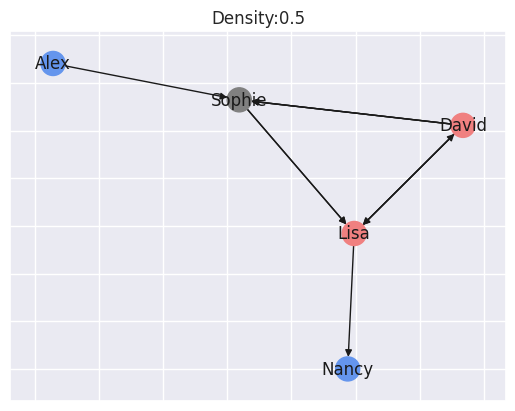

In [ ]:
G0 = results[0]["network"]
pos = nx.kamada_kawai_layout(G0) # pydot_layout
nx.draw_networkx(G0, labels=labs, pos=pos, node_color=color_map)
plt.title("Density:" + str(round(nx.density(G0),2)));

In [ ]:
Gmid = results[]["network"]
nx.draw_networkx(Gmid,labels=labs, pos=pos, node_color=color_map)
plt.title("Density:" + str(round(nx.density(Gmid),2)));

IndexError: list index out of range

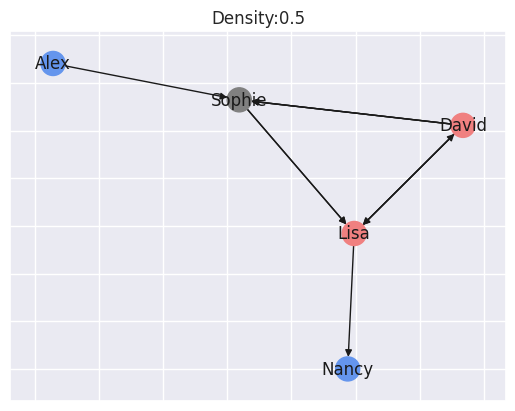

In [ ]:
Gfin = results[-1]["network"]
nx.draw_networkx(Gfin,labels=labs, pos=pos,  node_color=color_map)
plt.title("Density:" + str(round(nx.density(Gfin),2)));

In [ ]:
nx.community.louvain_communities(G0)

[{3}, {2, 5}, {0, 1, 4, 6}]

In [ ]:
nx.community.louvain_communities(Gfin)

[{0, 1, 6}, {3}, {2, 4, 5}]

In [ ]:
results[-1]["corpus"].print_summary_stats()

Number of Speakers: 7
Number of Utterances: 31
Number of Conversations: 18


In [ ]:
results[-1]["homefeed"].print_summary_stats()

Number of Speakers: 7
Number of Utterances: 11
Number of Conversations: 5


In [ ]:
results_df

,RunId,iteration,Step,agent_descriptions,llmprompts,topics,num_post_see,num_post_read,P_read_timeline,P_post_about_topic,seed,corpus,network,AgentID,handle,pos,likes,retweets,timeline,homefeed
0,0,0,0,"Lisa::You are @Lisa, a staunch Republican vote...",tweet_prompt::<|system|>\n[DESCRIPTION]</s>\n<...,Democrats\nRepublicans\nTrump\nBiden,3,3,0.6,0.8,123,,"(0, 1, 2, 3, 4, 5, 6)",Lisa,Lisa,0,[],[],[],
1,0,0,0,"Lisa::You are @Lisa, a staunch Republican vote...",tweet_prompt::<|system|>\n[DESCRIPTION]</s>\n<...,Democrats\nRepublicans\nTrump\nBiden,3,3,0.6,0.8,123,,"(0, 1, 2, 3, 4, 5, 6)",Alex,Alex,4,[],[],[],
2,0,0,0,"Lisa::You are @Lisa, a staunch Republican vote...",tweet_prompt::<|system|>\n[DESCRIPTION]</s>\n<...,Democrats\nRepublicans\nTrump\nBiden,3,3,0.6,0.8,123,,"(0, 1, 2, 3, 4, 5, 6)",David,David,6,[],[],[],
3,0,0,0,"Lisa::You are @Lisa, a staunch Republican vote...",tweet_prompt::<|system|>\n[DESCRIPTION]</s>\n<...,Democrats\nRepublicans\nTrump\nBiden,3,3,0.6,0.8,123,,"(0, 1, 2, 3, 4, 5, 6)",Nancy,Nancy,1,[],[],[],
4,0,0,0,"Lisa::You are @Lisa, a staunch Republican vote...",tweet_prompt::<|system|>\n[DESCRIPTION]</s>\n<...,Democrats\nRepublicans\nTrump\nBiden,3,3,0.6,0.8,123,,"(0, 1, 2, 3, 4, 5, 6)",Sophie,Sophie,2,[],[],[],
5,0,0,0,"Lisa::You are @Lisa, a staunch Republican vote...",tweet_prompt::<|system|>\n[DESCRIPTION]</s>\n<...,Democrats\nRepublicans\nTrump\nBiden,3,3,0.6,0.8,123,,"(0, 1, 2, 3, 4, 5, 6)",Jack,Jack,5,[],[],[],
6,0,0,0,"Lisa::You are @Lisa, a staunch Republican vote...",tweet_prompt::<|system|>\n[DESCRIPTION]</s>\n<...,Democrats\nRepublicans\nTrump\nBiden,3,3,0.6,0.8,123,,"(0, 1, 2, 3, 4, 5, 6)",Olivia,Olivia,3,[],[],[],
7,0,0,1,"Lisa::You are @Lisa, a staunch Republican vote...",tweet_prompt::<|system|>\n[DESCRIPTION]</s>\n<...,Democrats\nRepublicans\nTrump\nBiden,3,3,0.6,0.8,123,,"(0, 1, 2, 3, 4, 5, 6)",Lisa,Lisa,0,[],[],[],
8,0,0,1,"Lisa::You are @Lisa, a staunch Republican vote...",tweet_prompt::<|system|>\n[DESCRIPTION]</s>\n<...,Democrats\nRepublicans\nTrump\nBiden,3,3,0.6,0.8,123,,"(0, 1, 2, 3, 4, 5, 6)",Alex,Alex,4,[],[],[],
9,0,0,1,"Lisa::You are @Lisa, a staunch Republican vote...",tweet_prompt::<|system|>\n[DESCRIPTION]</s>\n<...,Democrats\nRepublicans\nTrump\nBiden,3,3,0.6,0.8,123,,"(0, 1, 2, 3, 4, 5, 6)",David,David,6,[],[],[],


In [ ]:
c = results[-7]["corpus"]

In [ ]:
results[-7]["handle"]

'Lisa'

In [ ]:
for convo in c.iter_conversations():
    print(convo.id)
    for utt in convo.iter_utterances():
        print(utt.speaker.id)
        print(utt.text)
        print(f"Retweets: {utt.meta['retweets']}; Likes {utt.meta['likes']}")
        print()

0
Lisa
-1
Retweets: 0; Likes 0

Alex
-1
Retweets: 0; Likes 0

David
-1
Retweets: 0; Likes 0

Nancy
-1
Retweets: 0; Likes 0

Sophie
-1
Retweets: 0; Likes 0

Jack
-1
Retweets: 0; Likes 0

Olivia
-1
Retweets: 0; Likes 0

8
Lisa
Biden's policies threaten our freedoms & endanger our national security. His radical agenda is a direct attack on the American way of life. We cannot afford to have him as our leader.
Retweets: 1; Likes 1

David
@Lisa, couldn't agree more! Biden's policies pose a grave danger to our country's future.
Retweets: 0; Likes 0

9
Alex
Democrats believe that every person deserves equal opportunities & access to resources, regardless of their background or identity. We're committed to fighting for social justice, protecting the environment, and ensuring quality healthcare for all.
Retweets: 1; Likes 1

Nancy
@Alex, couldn't have said it better myself! As a Californian Democrat, I wholeheartedly support your commitment to social justice, environmental protection, and access

In [ ]:
class LLMAgent(mesa.Agent):

    def __init__(self, self_description, model):

        super().__init__(self_description["handle"], model)

        self.handle = self_description["handle"]
        self.self_description = self_description["description"]

        self.homefeed = Corpus.from_pandas(pd.DataFrame({'id': range(len(self.model.agent_descriptions)),
                                'timestamp':[-self.model.num_post_see]*len(self.model.agent_descriptions),
                                'text':["-1"]*len(self.model.agent_descriptions),
                                'speaker': [agent["handle"] for agent in self.model.agent_descriptions],
                                'reply_to':[0]*len(self.model.agent_descriptions),
                                'conversation_id': [0]*len(self.model.agent_descriptions),
                                "meta.emb":[0]*len(self.model.agent_descriptions),
                                "meta.likes":[0]*len(self.model.agent_descriptions),
                                "meta.retweets":[0]*len(self.model.agent_descriptions),
                                "meta.topic":["topic"]*len(self.model.agent_descriptions)}))

        for speaker in self.homefeed.iter_speakers():
            speaker.add_meta("opinion",[])

        self.current_likes = []
        self.current_retweets = []
        self.current_timeline = []
        self.enough_posts = False

    def get_full_sents(self, post):
        punkt = {'!', '.', '?'}
        sents = [sent.text for sent in self.model.pos(post).sents]
        post = " ".join(sents[:-1]) if (len(sents) > 1) and (sents[-1][-1] not in punkt) else " ".join(sents)
        post = post.replace("\n","").replace('"',"").replace('#',"")
        return post

    def generate_post(self, prompt, reply_to=None, topic=None):
        post = self.model.generator_short(prompt)[0]["generated_text"].replace(prompt, "")
        post = self.get_full_sents(post)
        self.model.current_utt_id += 1

        full_post = convokit.Utterance(**{
                'id': str(self.model.current_utt_id),
                'timestamp': self.model.schedule.steps,
                "text": post,
                "speaker": self.model.corpus.get_speaker(self.handle),
                "reply_to": None if reply_to == None else reply_to["id"],
                "conversation_id": str(self.model.current_utt_id) if reply_to == None else reply_to["conversation_id"],
                "meta": {"likes": 0, "retweets": 0, "topic": reply_to["id"].meta["topic"] if topic==None else topic}
                })

        self.model.corpus.add_utterances([full_post])
        self.homefeed.add_utterances([full_post])

        print(full_post.speaker.id + " wrote:\n\t" + full_post.text)
        return full_post


    def follow(self, speaker, full_convo_text):
        prompt = self.model.prompts["follow_prompt"]
        if len(speaker.meta["opinion"]) != 0:
            prompt = prompt.replace("[OPINION]", f'You have previously described [SPEAKER] as: "{speaker.meta["opinion"][-1][0]}".')
        else:
            prompt = prompt.replace("[OPINION]", "")
        prompt = prompt.replace("[DESCRIPTION]", self.self_description).replace("[TWEET]", full_convo_text).replace("[SPEAKER]", f"@{speaker.id}").replace("[HANDLE]",self.handle)
        follow = self.model.generator_short(prompt)[0]["generated_text"].replace(prompt, "")
        if "yes" in follow.lower():
            agent = self.model.agents[self.model.agent_order[speaker.id]]
            self.model.grid.G.add_edge(self.pos,agent.pos)
            print(f"\t{self.handle} started following {agent.handle}")


    def unfollow(self, speaker, full_convo_text):
        prompt = self.model.prompts["unfollow_prompt"]
        if len(speaker.meta["opinion"]) != 0:
            prompt = prompt.replace("[OPINION]", f'You have previously described [SPEAKER] as: "{speaker.meta["opinion"][-1][0]}".')
        else:
            prompt = prompt.replace("[OPINION]", "")
        prompt = prompt.replace("[DESCRIPTION]", self.self_description).replace("[TWEET]", full_convo_text).replace("[SPEAKER]", f"@{speaker.id}").replace("[HANDLE]",self.handle)
        follow = self.model.generator_short(prompt)[0]["generated_text"].replace(prompt, "")
        if "yes" in follow.lower():
            agent = self.model.agents[self.model.agent_order[speaker.id]]
            self.model.grid.G.remove_edge(self.pos,agent.pos)
            print(f"\t{self.handle} unfollowed {agent.handle}")


    def push_to_followers(self,post_convo):
        # pushes a post to all the people who follow this agent
        followers = self.model.grid.get_followers(self.pos)
        for follower in followers:
            if follower.handle != self.handle:
                for utt in post_convo:
                    if not follower.homefeed.has_utterance(utt.id):
                        follower.homefeed.add_utterances([utt])


    def get_speaker_opinion(self, speaker, full_convo_text):
        # helper
        if len(speaker.meta["opinion"]) != 0:
            prompt = self.model.prompts["opinion_prompt"].replace("[OPINION]", speaker.meta["opinion"][-1][0])
        else:
            prompt = self.model.prompts["first_opinion_prompt"]

        prompt = prompt.replace("[DESCRIPTION]", self.self_description).replace("[TWEET]", full_convo_text).replace("[SPEAKER]", f"@{speaker.id}").replace("[HANDLE]",self.handle)
        opinion = self.model.generator_short(prompt)[0]["generated_text"].replace(prompt, "")
        opinion = self.get_full_sents(opinion)

        speaker.meta["opinion"].append([opinion,self.model.schedule.steps])


    def read_convo(self,convo_obj):
        # helper function that creates conversation as one text
        utt_list = convo_obj.get_chronological_utterance_list()[-self.model.num_post_read:]
        full_convo_text = ""
        for i, utt in enumerate(utt_list):
            speaker = f"@{utt.speaker.id}" if utt.speaker.id != self.handle else "You"
            if i == 0:
                full_convo_text += f'{speaker} wrote: "{utt.text}"\n'
            else:
                full_convo_text += f'{speaker} replied: "{utt.text}"\n'
        return utt_list, full_convo_text


    def reply_to_convo(self, convo, utt_list, full_convo_text):
        # helper function that replies to a post in a cnoversation
        prompt = self.model.prompts["tweet_prompt"]
        if len(utt_list[-1].speaker.meta["opinion"]) != 0:
            prompt = prompt.replace("[OPINION]", f'You have previously described @{utt_list[-1].speaker.id} as: "{utt_list[-1].speaker.meta["opinion"][-1][0]}".')
        else:
            prompt = prompt.replace("[OPINION]", "")
        prompt = prompt.replace("[DESCRIPTION]", self.self_description).replace("[TWEET]",full_convo_text).replace("[HANDLE]",self.handle)
        post = self.generate_post(prompt, reply_to={"conversation_id":convo,"id":utt_list[-1]})
        post_convo = self.model.corpus.get_conversation(convo).get_chronological_utterance_list()
        self.push_to_followers(post_convo)


    def like(self, convo, utt_list, full_convo_text):
        prompt = self.model.prompts["like_prompt"]
        prompt = prompt.replace("[DESCRIPTION]", self.self_description).replace("[TWEET]", full_convo_text).replace("[HANDLE]",self.handle)
        like = self.model.generator_short(prompt)[0]["generated_text"].replace(prompt, "")
        if "yes" in like.lower():
            print(f"\t{self.handle} liked post #{utt_list[-1].id}")
            utt_list[-1].meta["likes"] += 1
            self.current_likes.append([self.handle,utt_list[-1].id,self.model.schedule.steps])


    def repost(self, convo, utt_list, full_convo_text):
        prompt = self.model.prompts["repost_prompt"]
        prompt = prompt.replace("[DESCRIPTION]", self.self_description).replace("[TWEET]", full_convo_text).replace("[HANDLE]",self.handle)
        repost = self.model.generator_short(prompt)[0]["generated_text"].replace(prompt, "")
        if "yes" in repost.lower():
            print(f"\t{self.handle} reposted post #{utt_list[-1].id}")
            utt_list[-1].meta["retweets"] += 1
            self.current_retweets.append([self.handle,utt_list[-1].id,self.model.schedule.steps])

            full_convo = self.homefeed.get_conversation(convo).get_chronological_utterance_list()
            self.push_to_followers(full_convo)


    def reply(self, convo, utt_list, full_convo_text):
        prompt = self.model.prompts["reply_prompt"]
        if len(utt_list[-1].speaker.meta["opinion"]) != 0:
            prompt = prompt.replace("[OPINION]", f'You have previously described @{utt_list[-1].speaker.id} as: "{utt_list[-1].speaker.meta["opinion"][-1][0]}".')
        else:
            prompt = prompt.replace("[OPINION]", "")
        prompt = prompt.replace("[DESCRIPTION]", self.self_description).replace("[TWEET]", full_convo_text).replace("[HANDLE]",self.handle)
        reply = self.model.generator_short(prompt)[0]["generated_text"].replace(prompt, "")
        if "yes" in reply.lower():
            print(f"\t{self.handle} replied to post #{utt_list[-1].id}")
            self.reply_to_convo(convo, utt_list, full_convo_text)
            return True
        else:
            return False


    def read_timeline(self, convos):
        for convo in convos:
            print("\tConvo #" + convo)
            convo_obj = self.homefeed.get_conversation(convo)

            if convo_obj.get_chronological_utterance_list()[-1].speaker.id != self.handle:

                utt_list, full_convo_text = self.read_convo(convo_obj)

                # decide if you want to like a post (&like it)
                self.like(convo, utt_list, full_convo_text)
                # decide if you want to repost (&repost)
                self.repost(convo, utt_list, full_convo_text)

                followings = [following.handle for following in self.model.grid.get_following(self.pos)]
                speakers_in_utt_list = [utt.speaker for utt in utt_list]
                for speaker_obj in set(speakers_in_utt_list):
                    if speaker_obj.id != self.handle:
                        self.get_speaker_opinion(speaker_obj, full_convo_text)

                        if speaker_obj.id not in set(followings):
                            # decide if you want to follow (&follow)
                            self.follow(speaker_obj, full_convo_text)
                        elif speaker_obj.id in set(followings):
                            # decide if you want to unfollow (&unfollow)
                            self.unfollow(speaker_obj, full_convo_text)
                        else:
                            pass

                if self.reply(convo, utt_list, full_convo_text):
                    # stop the loop as soon as you chose to & replied to a convo
                    break


    def step(self):
        print()
        print("Agent "+self.handle+" active")
        p = self.model.random.random()
        self.current_likes = []
        self.current_retweets = []

        if not self.enough_posts:
            self.enough_posts = True if self.model.num_post_see + len(self.model.agent_descriptions) <= len([utt for utt in self.homefeed.iter_utterances()]) else False

        if p <= self.model.P1:
            if self.enough_posts:
                self.current_timeline = self.model.feed_algorithm(self)
                self.read_timeline(self.current_timeline)
            else:
                topic = self.random.choice(self.model.topics)
                prompt = self.model.prompts["second_prompt"].replace("[DESCRIPTION]", self.self_description).replace("[TOPIC]", topic)
                previous_posts = [f' - "{self.homefeed.get_utterance(id).text}"' for id in self.homefeed.get_speaker(self.handle).get_utterance_ids(lambda utt: True if utt.meta["topic"]==topic and utt.reply_to==None else False)]
                prompt = prompt.replace("[PREVIOUSPOSTS]", "\n".join(previous_posts))
                post = self.generate_post(prompt,topic=topic)
                self.push_to_followers([post])

        elif self.model.P1 < p <= self.model.P1 + self.model.P2:
            topic = self.random.choice(self.model.topics)
            prompt = self.model.prompts["first_prompt"].replace("[DESCRIPTION]", self.self_description).replace("[TOPIC]",topic)
            post = self.generate_post(prompt,topic=topic)
            self.push_to_followers([post])

        else:
            pass


